imports

In [ ]:
import numpy as np
import os,sys,glob
import matplotlib.pyplot as plt
import re
import fnmatch
import h5py
import csv
# import seaborn as sns
# sns.set(style='ticks', context='talk') #aesthetics
# plt.style.use("dark_background") #aesthetics

In [ ]:
import openephys.OpenEphys as oe
from braintv_ephys_dev.workstation.danield.generalephys import option234_positions
def get_chunk(mm,start,end,channels,sampling_rate=30000):
	duration = end - start
	samples = int(np.round(duration * sampling_rate))
	start_sample = int(start*sampling_rate)*int(channels)
	chunk = mm[start_sample:\
			   start_sample + samples * int(channels)]#int(int(np.floor(np.ceil(end*sampling_rate))*(int(channels))))]
	#print np.shape(chunk)
	return np.reshape(chunk,(int(channels),-1),order='F')  * (0.195)

In [1]:
def load_phy_spiketimes(path):
    all_spiketimes = []
    all_cluster_numbers = []

    clusters_data = np.load(os.path.join(path,'spike_clusters.npy'))
    spikes_data = np.load(os.path.join(path,'spike_times.npy'))
    spike_templates = np.load(os.path.join(path,'spike_templates.npy'))
    templates = np.load(os.path.join(path,'templates.npy'))

    cluster_groups = []
    [cluster_groups.append(row) for row in csv.reader(open(os.path.join(path,'cluster_group.tsv')))];
    spiketime_information = {}
    for i in np.arange(1,np.shape(cluster_groups)[0]):
        if cluster_groups[i][0].split('\t')[1] == 'good':           #if it is a 'good' cluster by manual sort
            unit = int(cluster_groups[i][0].split('\t')[0])
            spiketime_information[str(unit)] = {}

            spiketime_information[str(unit)]['spike_times'] = spikes_data[np.where(clusters_data==unit)]/30000.    
            spiketime_information[str(unit)]['spike_times']= spiketime_information[str(unit)]['spike_times'].flatten()

            #get the mean template used for this unit
            all_templates = spike_templates[np.where(clusters_data==unit)].flatten()
            n_templates_to_subsample = 100
            random_subsample_of_templates = templates[all_templates[np.array(np.random.rand(n_templates_to_subsample)*all_templates.shape[0]).astype(int)]]
            mean_template = np.mean(random_subsample_of_templates,axis=0)
            spiketime_information[str(unit)]['template'] = mean_template

            #take a weighted average of the channelmap, where the weights is the absolute value of the template for that channel
            #this gets us the x and y positions of the unit on the probe.
    #         if 'channelmap' in kwargs.keys():
    #             channelmap = kwargs['channelmap']
    #             weights = np.zeros(channelmap.shape)
    #             for channel in range(channelmap.shape[0]):
    #                 weights[channel,:]=np.trapz(np.abs(mean_template.T[channel,:]))
    #             weights = weights/np.max(weights)
    #             (xpos,ypos)=np.average(channelmap,axis=0,weights=weights)
    #         else:
            (xpos,ypos)=(np.nan,np.nan)
    #         spiketime_information[str(unit)]['xpos'] = xpos + 6
    #         spiketime_information[str(unit)]['ypos'] = ypos - channelmap[-1][1]

            all_spiketimes.extend(spiketime_information[str(unit)]['spike_times'])
            all_cluster_numbers.extend(np.array(np.ones(len(spiketime_information[str(unit)]['spike_times']))*unit).tolist())
    return spiketime_information

# define paths here
these should be full paths [string]

In [ ]:
slice_nwb_path = np.sort(glob.glob('/Users/danieljdenman/Desktop/cache/meanhwan/2019-06-25_14-59-04/*.nwb'))[0]
path = os.path.join(os.path.dirname(slice_nwb_path),'sort1')

## load data from pipettes and sorted neuropixels data

In [ ]:
d = h5py.File(slice_nwb_path)
spiketime_information = load_phy_spiketimes()path

## load sync data from pipettes and sorted neuropixels data

In [12]:
TTL0 = np.array([list(d['stimulus']['presentation'][k]['starting_time'])[0] for k in fnmatch.filter(list(d['stimulus']['presentation']), 'data_*_TTL0*')]             )
npix_events = oe.loadEvents(glob.glob(os.path.join(os.path.dirname(slice_nwb_path),'*channels*.events'))[0])
ch0 = npix_events['timestamps'][npix_events['channel']==0] - start_time


loading events...


In [13]:
start_time = int(open(glob.glob(os.path.join(os.path.dirname(slice_nwb_path),'*messages*.events'))[0]).readlines()[0].split(' ')[0])/30000.


compare the events from the two systems

(0.9, 1.3)

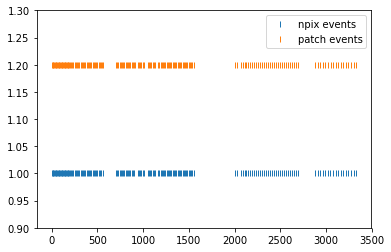

In [15]:
npix_ch0_times = ch0[8:][::2]/30000.
patch_ch0_times = TTL0[672 - int(len(ch0)/2):671]
plt.plot(npix_ch0_times-npix_ch0_times[0],np.ones(len(npix_ch0_times)),'|',label='npix events')
plt.plot(patch_ch0_times - patch_ch0_times[0],np.ones(len(patch_ch0_times))*1.2,'|',label='patch events')
plt.legend()
plt.ylim(0.9,1.3)
# plt.xlim(2000,2100)

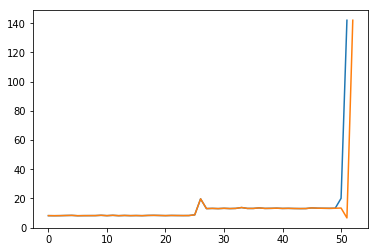

In [16]:
plt.plot(np.diff(npix_ch0_times[:5d3]))
plt.plot(np.diff(patch_ch0_times[:54]))

In [17]:
patch_ch0_mask = np.ones(len(patch_ch0_times), dtype=bool)
patch_ch0_mask[52]=False
patch_ch0_mask[53]=False
patch_ch0_redacted = patch_ch0_times[patch_ch0_mask]

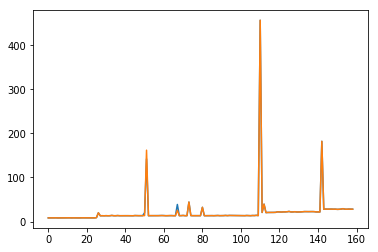

In [18]:
plt.plot(np.diff(npix_ch0_times))
# plt.plot(np.diff(patch_ch0_times[patch_ch0_mask]))
plt.plot(np.diff(patch_ch0_redacted))


In [ ]:
patch_ch0_times = patch_ch0_redacted

In [ ]:
offset= npix_ch0_times[0]-start_time - patch_ch0_times[0]

digest some pipette data

In [ ]:
pip3_spike_times = []
for tr in fnmatch.filter(list(d['acquisition']['timeseries']), 'data_*_AD3*'):
    starting_time = np.array(d['acquisition']['timeseries'][tr]['starting_time'])[0]    
    temp=np.array(d['acquisition']['timeseries'][tr]['data'])    
    tts = cross_from_below(temp,0)/d['acquisition']['timeseries'][tr]['starting_time'].attrs['rate'] + starting_time + offset - .252265
    pip3_spike_times.extend(tts)

interactive plot of neuropixels data with pipette data

pipette spike triggered average of neuropixels

In [ ]:
plt.imshow(spiketime_information[cell]['template'].T)
plt.figure()
good = []
for i,ch in enumerate(spiketime_information[cell]['template'].T):
    x_ = option234_positions[::-1][i][0]*5
    y_ = option234_positions[::-1][i][1]
    plt.plot(np.linspace(x_,x_+len(ch),len(ch)),ch+y_*.003,'k')
    if np.max(np.abs(ch)) > 0.05: good.extend([ch])
# plt.ylim(-.2,.1)
plt.title('channels with signal > 50uv: '+str(len(good)))
# plt.gcf().savefig(os.path.join('/Users/danieljdenman/Dropbox/allenTransfer/invitropanels','npix_template.png'),format='png',dpi=600)